*By: Dmitrii Vyacheslavovich Velibekov*

# Imports

In [2]:
import math
import matplotlib.pyplot as plt
from itertools import permutations, product
import numpy as np
import pandas as pd
from collections import Counter
from Lorentz import Lorentz
from TSProcessor import TSProcessor
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

%config Completer.use_jedi = False
%config InlineBackend.figure_format='retina'
%matplotlib inline
plt.style.use('seaborn-whitegrid')

# Timeseries

## Lorenz timeseries

In [3]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

def denormalize(arr, min, max):
    return arr * (max - min) + min

In [4]:
x, _, _ = Lorentz().generate(0.1, 100000)
lorenz_max, lorenz_min = x.max(), x.min()
lorenz_ts = normalize(x)[256:]

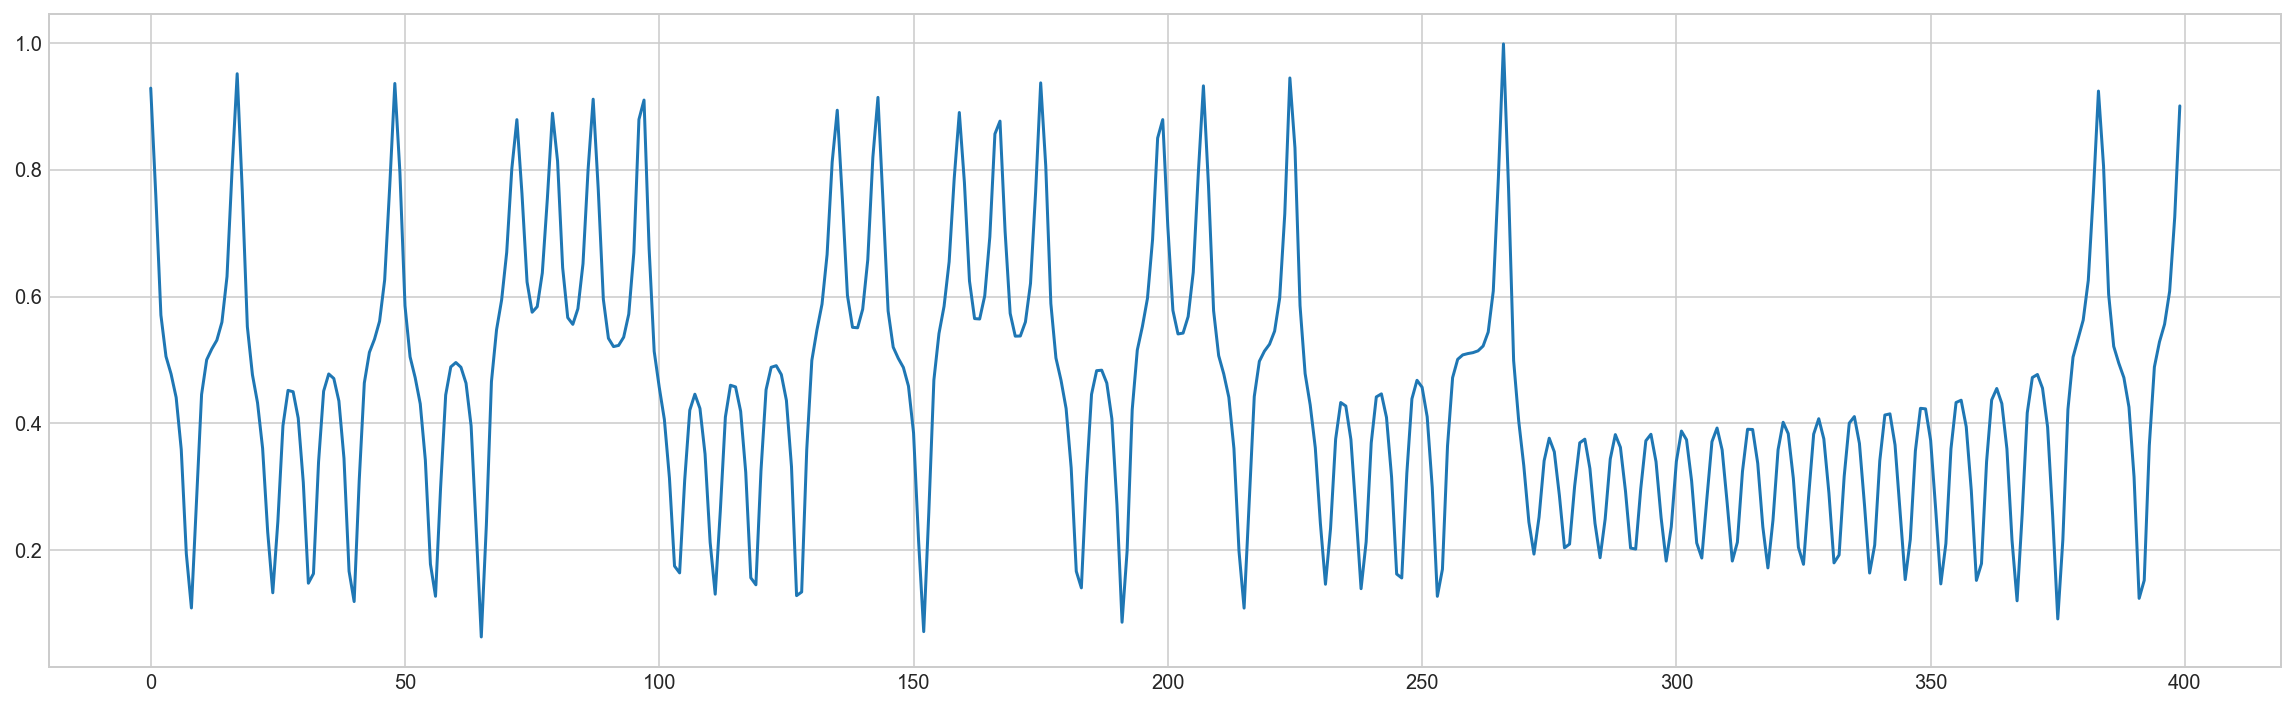

In [8]:
plt.figure(figsize=(20, 6))
plt.plot(lorenz_ts[456:856]);

## Energy in Germany

In [9]:
ger_txt = np.loadtxt('data/energy_in_germany.txt', delimiter=',')
ger_max, ger_min = ger_txt.max(), ger_txt.min()
ger_ts = normalize(ger_txt)

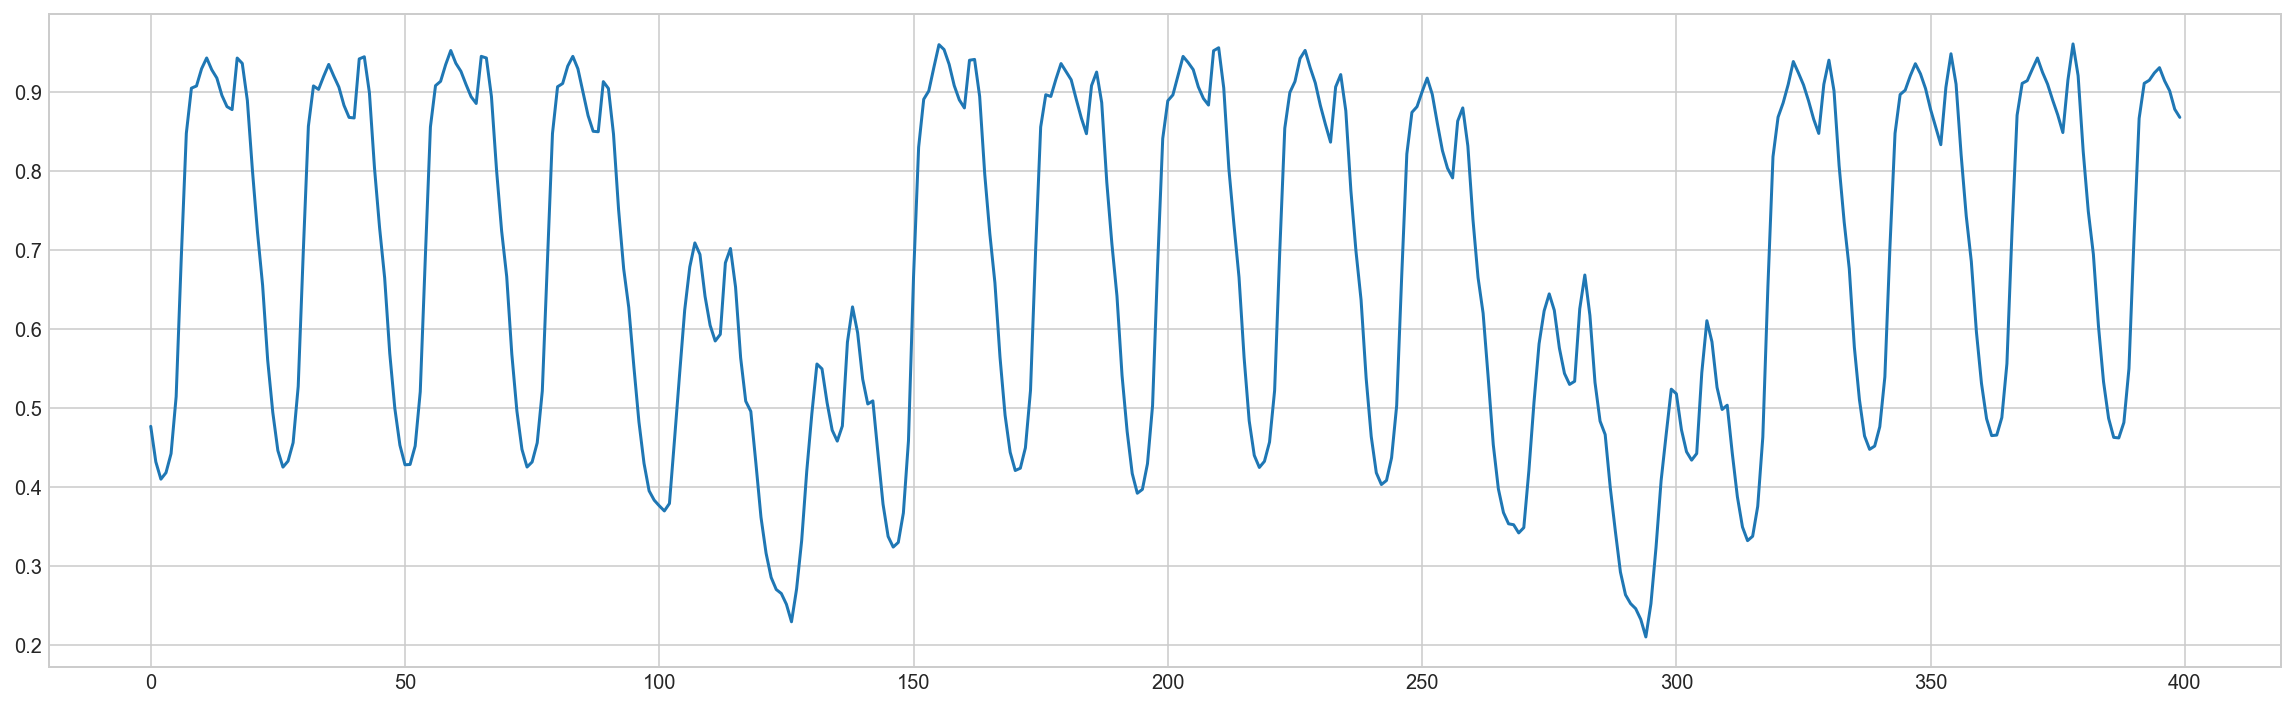

In [10]:
plt.figure(figsize=(20, 6))
plt.plot(ger_ts[456:856]);

## FX EUR-USD

In [11]:
fx_df = pd.read_csv('data/FX_EURUSD, 1.csv')
fx_df.head()

,time,open,high,low,close
0,2020-04-03T20:58:00Z,1.08088,1.08090,1.08063,1.08063
1,2020-04-05T21:03:00Z,1.08100,1.08103,1.08100,1.08103
2,2020-04-05T21:07:00Z,1.08103,1.08105,1.08103,1.08105
3,2020-04-05T21:10:00Z,1.08105,1.08112,1.08100,1.08107
4,2020-04-05T21:11:00Z,1.08107,1.08109,1.08098,1.08104


We will pick values on closure

In [12]:
fx_max, fx_min = fx_df['close'].max(), fx_df['close'].min()
fx_ts = normalize(fx_df['close'].values)

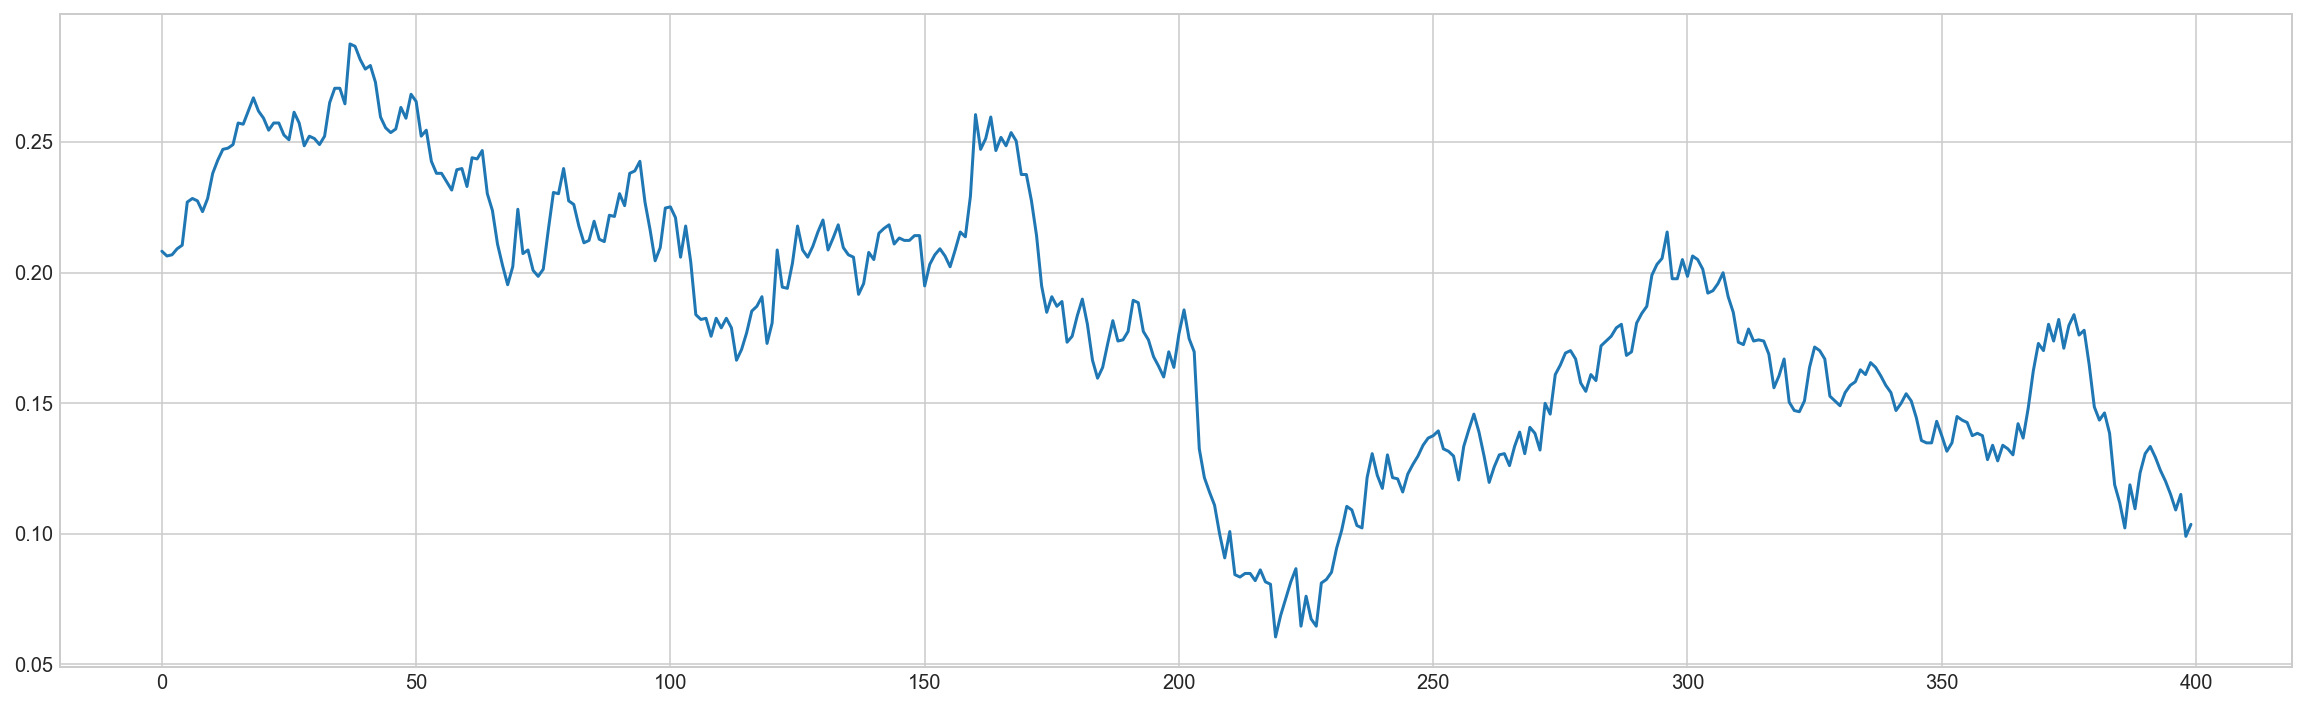

In [13]:
plt.figure(figsize=(20, 6))
plt.plot(fx_ts[456:856]);

# Entropy - complexity plane

## Find point

In [14]:
def bandt_pompe(ts, d):
    # transform timeseries to list of D-previous values at each timestep
    ts_transformed = [ts[i-d: i] for i in range(d, len(ts) + 1)]
    
    # all possible permutations,
    # subtract counter from itself to start count from 0     
    c = Counter(permutations(range(d), d))
    c.subtract(c)
    
    # for every permutation count number of occurences
    # occurences are converted from values to "order of sorting"
    c.update(map(tuple, (d - 1) - np.argsort(ts_transformed)))
    
    # convert number of occurences to probabilities
    return [n / len(ts_transformed) for n in c.values()] 


def uniform_dist(d):
    # uniform distribution [1/D!, 1/D!, ...., 1/D!] of length D!
    permutation_number = math.factorial(d)
    return [1 / permutation_number] * permutation_number

In [15]:
def entropy(distr):
    # Shannon's entropy calculation
    return -sum([p * np.log(p) for p in distr if p != 0])


def entropic_measure(distr, d):
    # one of two axis values for entropy-complexety plane
    return entropy(distr) / np.log(math.factorial(d))


def normalizaion_coef(d):
    distr = [0] * math.factorial(d)
    distr[0] = 1
    buff = uniform_dist(d)
    buff = [(i + j) / 2 for i, j in zip(distr, buff)]
    return 1 / (entropy(buff) - entropy(distr)
                / 2 - np.log(math.factorial(d)) / 2)


def divergence(distr, d):
    # Jensen-Shannon divergence with normalization coefficient calculation
    buff = uniform_dist(d)
    buff = [(i + j) / 2 for i, j in zip(distr, buff)]
    return normalizaion_coef(d) * (entropy(buff) - entropy(distr) / 2
                                   - np.log(math.factorial(d)) / 2)

In [25]:
def complexity_entropy(ts, d):
    pdf = bandt_pompe(ts, d)
    h = entropic_measure(pdf, d)
    c = divergence(pdf, d) * h
    return (h, c)

## Find borders

In [31]:
def s_b(N, p, m, n):
    if p != 0:
        return -(n * p * math.log(p)
                 + (N - m - n) * (1 - p * n) / (N - m - n)
                 * math.log((1 - p * n) / (N - m - n)))
    else:
        return math.log(N - m - n)

def s_b_1(N, p, m, n):
    return -(m / N * math.log(1 / N)
             + n * (p + 1 / N) / 2 * math.log((p + 1 / N) / 2)
             + (N - m - n) * ((1 - p * n) / (N - m - n) + 1 / N) / 2 \
             * math.log((((1 - p * n) / (N - m - n)) + 1 / N) / 2))

def entropy_measure_b(N, p, m, n):
    return s_b(N, p, m, n) / math.log(N)

def q_0_calculation_b(N, p, m, n):
    return 1 / (s_b(N, 1 / 2 / N, 0, N - 1) - math.log(N) / 2)

def q_j_b(N, p, m, n):
    return q_0_calculation_b(N, p, m, n) * (s_b_1(N, p, m, n)
                                            - s_b(N, p, m, n) / 2
                                            - math.log(N) / 2)

def mpr_complexity_b(N, p, m, n):
    return q_j_b(N, p, m, n) * entropy_measure_b(N, p, m, n)

def borders(N, d):
    x1, y1, x2, y2 = [], [], [], []
    y1 = []
    i = 1
    while (i * 100 < N):
        for n in range (N - i * 100, N - 1, i):
            x1.append(entropy_measure_b(N, 0, 0, n))
            y1.append(mpr_complexity_b(N, 0, 0, n))
        i *= 2
    for n in range (0, N - 1, i):
        x1.append(entropy_measure_b(N, 0, 0, n))
        y1.append(mpr_complexity_b(N, 0, 0, n))
    upper = list(zip(*sorted(zip(x1, y1))))
    
    p = 0.01
    while p < 0.99:
        p += 0.01
        x2.append(entropy_measure_b(N, p, 0, 1))
        y2.append(mpr_complexity_b(N, p, 0, 1))
    
    plt.plot(upper[0], upper[1], c='red')
    plt.plot(x2, y2, c='green')
    plt.xlabel('entropy')
    plt.ylabel('mpr_complexity')
    plt.title(f'D = {d}')

## Check Lorenz timeseries

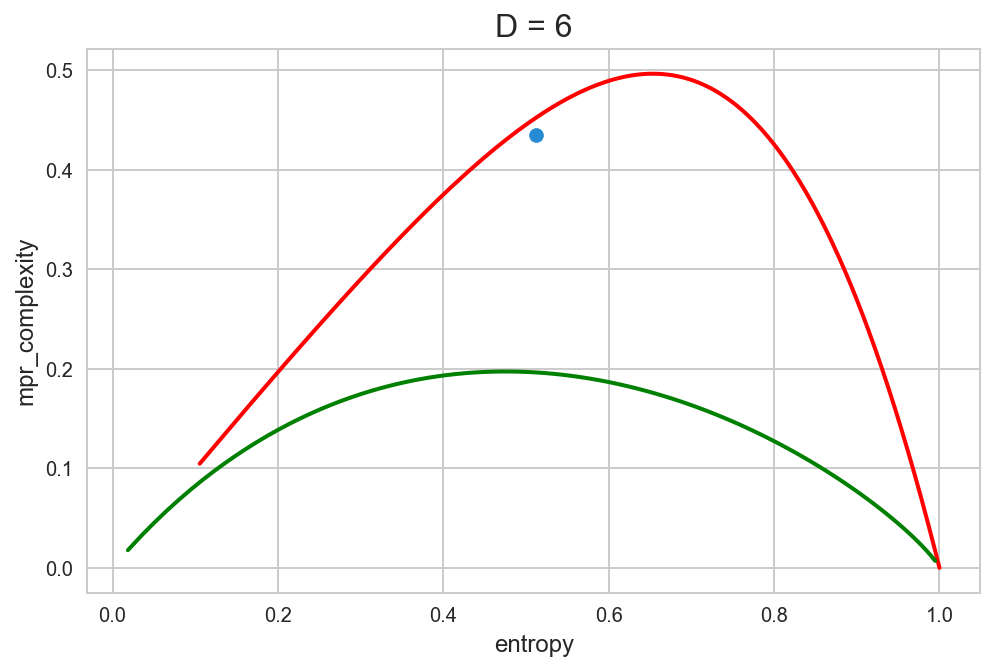

In [96]:
plt.figure(figsize=(8, 5))
h, c = complexity_entropy(lorenz_ts, 6)
borders(720, 6)
plt.scatter(h, c);

Point is near the apex, so this timeseries can be considered as chaotic.

## Check German energy timeseries

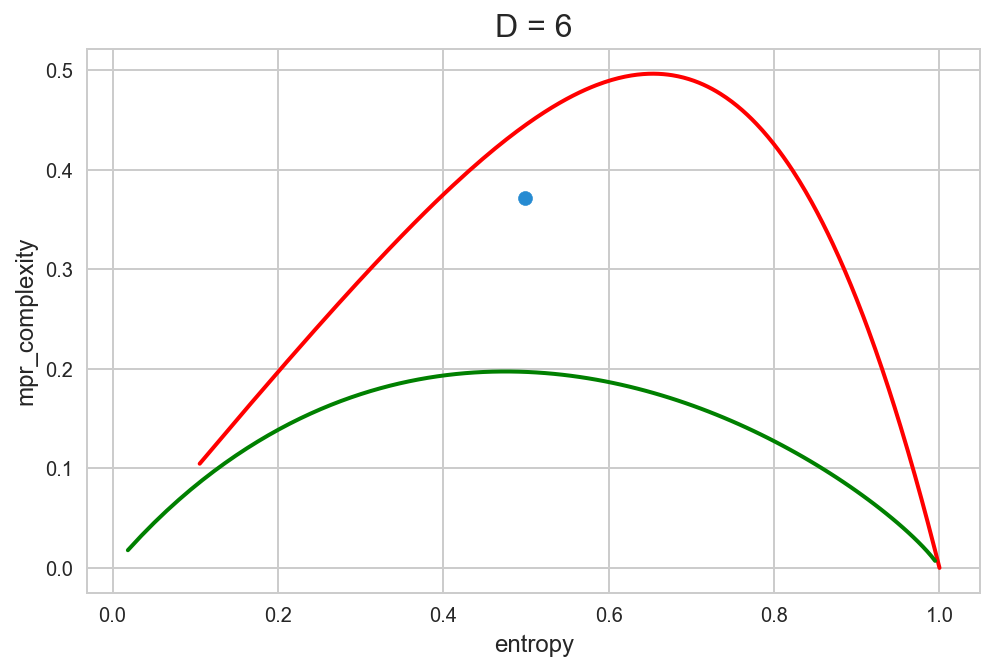

In [97]:
plt.figure(figsize=(8, 5))
h, c = complexity_entropy(ger_ts, 6)
borders(720, 6)
plt.scatter(h, c);

Point is quite far from the apex, although not a lot, and trends to the left side, so this timeseries can be considered as partially chaotic partially deterministic.

## Check EUR-USD FX timeseries

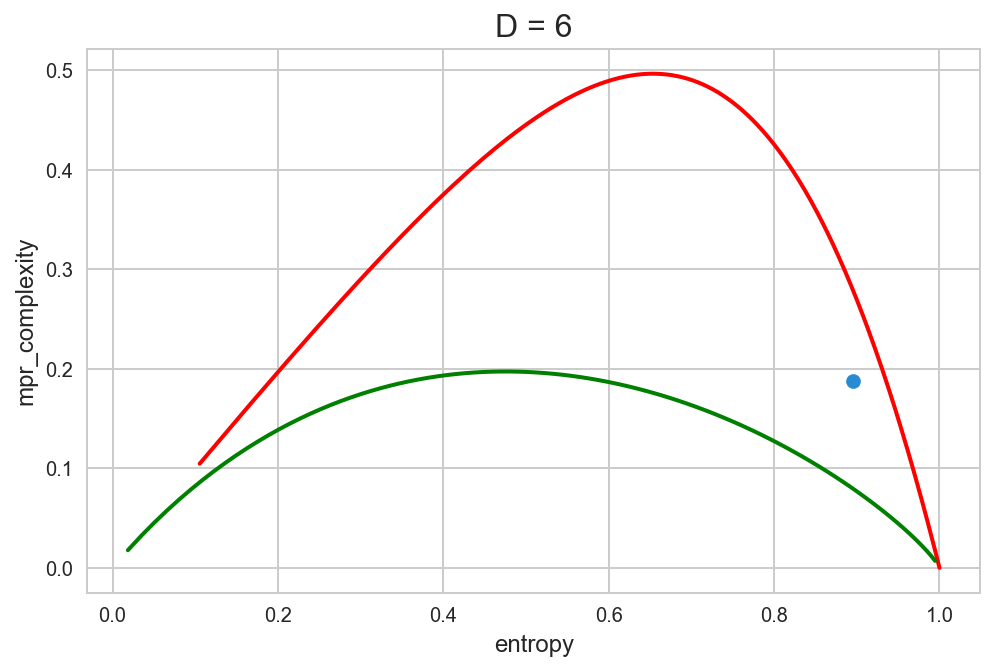

In [98]:
plt.figure(figsize=(8, 5))
h, c = complexity_entropy(fx_ts, 6)
borders(720, 6)
plt.scatter(h, c);

Point is near the region with high entropy and low complexity, which resembles stohastic processes.

# Predictive clustering

## Fitting/ predicting

In [183]:
def get_predictions(tsp, steps, eps, n_tr,
                    noise_amp, dbs_eps, dbs_min_samples):
    
    forecast_sets = tsp.pull(steps=steps,
                             eps=eps,
                             n_trajectories=n_tr,
                             noise_amp=noise_amp)
    avg_predict = forecast_sets.mean(axis=1)
    with_non_predict = tsp.cluster_sets(forecast_sets,
                                        dbs_eps,
                                        dbs_min_samples)
    return avg_predict, with_non_predict, forecast_sets

In [16]:
def plot_predict(ts, split, steps, eps, n_tr, noise_amp,
                 patt_len, max_spread, dbs_eps, dbs_min_samples):
    
    tsp = TSProcessor(patt_len, max_spread)
    tsp.fit(ts[:split])
    _, result, forecast_sets  = get_predictions(tsp, steps, eps,
                                                n_tr, noise_amp,
                                                dbs_eps,
                                                dbs_min_samples)
    
    fig, ax = plt.subplots(2, 1, figsize=(16, 14))
    ax[0].plot(ts[split:split+steps])
    ax[0].scatter(range(result.size), result, c='orange')
    ax[0].plot(range(result.size), result, c='orange')
    ax[1].plot(ts[split:split+steps])

    for i in range(len(forecast_sets)):
        ax[1].scatter(np.repeat(i, len(forecast_sets[i])),
                      forecast_sets[i], c = 'orange')
        ax[1].plot([i, i],
                   [min(forecast_sets[i]), max(forecast_sets[i])],
                   c = 'orange');
    
    ax[0].title.set_text(f'Prediction for {steps} steps ahead')
    ax[1].title.set_text('Trajectories dispersion')

## Calculating errors

In [184]:
def mape_rmse_non_predict(truth, predict):
    non_predict = np.isnan(predict).sum()
    mape = 100 * np.nanmean(np.abs((truth - predict) / truth))
    rmse = np.sqrt(np.nanmean((truth - predict) ** 2))
    return mape, rmse, non_predict

## Error plots

In [194]:
def error_plots(ts, split, steps_list, eps, n_tr,
                noise_amp, patt_len, max_spread,
                dbs_eps, dbs_min_samples):
    
    tsp = TSProcessor(patt_len, max_spread)
    avg_list = []
    non_pred_list = []
    for steps in tqdm(steps_list):
        tsp.fit(ts[:split])
        avg, non_predict, _ = get_predictions(tsp, steps, eps,
                                              n_tr, noise_amp,
                                              dbs_eps,
                                              dbs_min_samples)
        avg_list.append(mape_rmse_non_predict(ts[split:split+steps],
                                              avg))
        non_pred_list.append(mape_rmse_non_predict(ts[split:split+steps],
                                                   non_predict))
    
    avg_errs = list(zip(*avg_list))
    non_pred_errs = list(zip(*non_pred_list))
    
    fig, ax = plt.subplots(3,1, figsize=(12, 18))
    names = ['MAPE', 'RMSE', 'Non-predictable points']
    for i in range(3):
        ax[i].title.set_text(names[i])
        ax[i].plot(steps_list, avg_errs[i], c='blue',
                   label='Averaging without non-predictables')
        ax[i].plot(steps_list, non_pred_errs[i], c='orange',
                   label='With non-predictables')
        ax[i].legend()

## Lorenz timeseries predicting

Let's visualize prediction for 100 steps using predictive clustering method:

In [186]:
split = 1000
steps_list = range(4, 102, 2)
steps = 100
eps = 0.01
n_tr = 10
noise_amp = 0.05
patt_len = 4
max_spread = 10
dbs_eps = 0.05
dbs_min_samples = 7

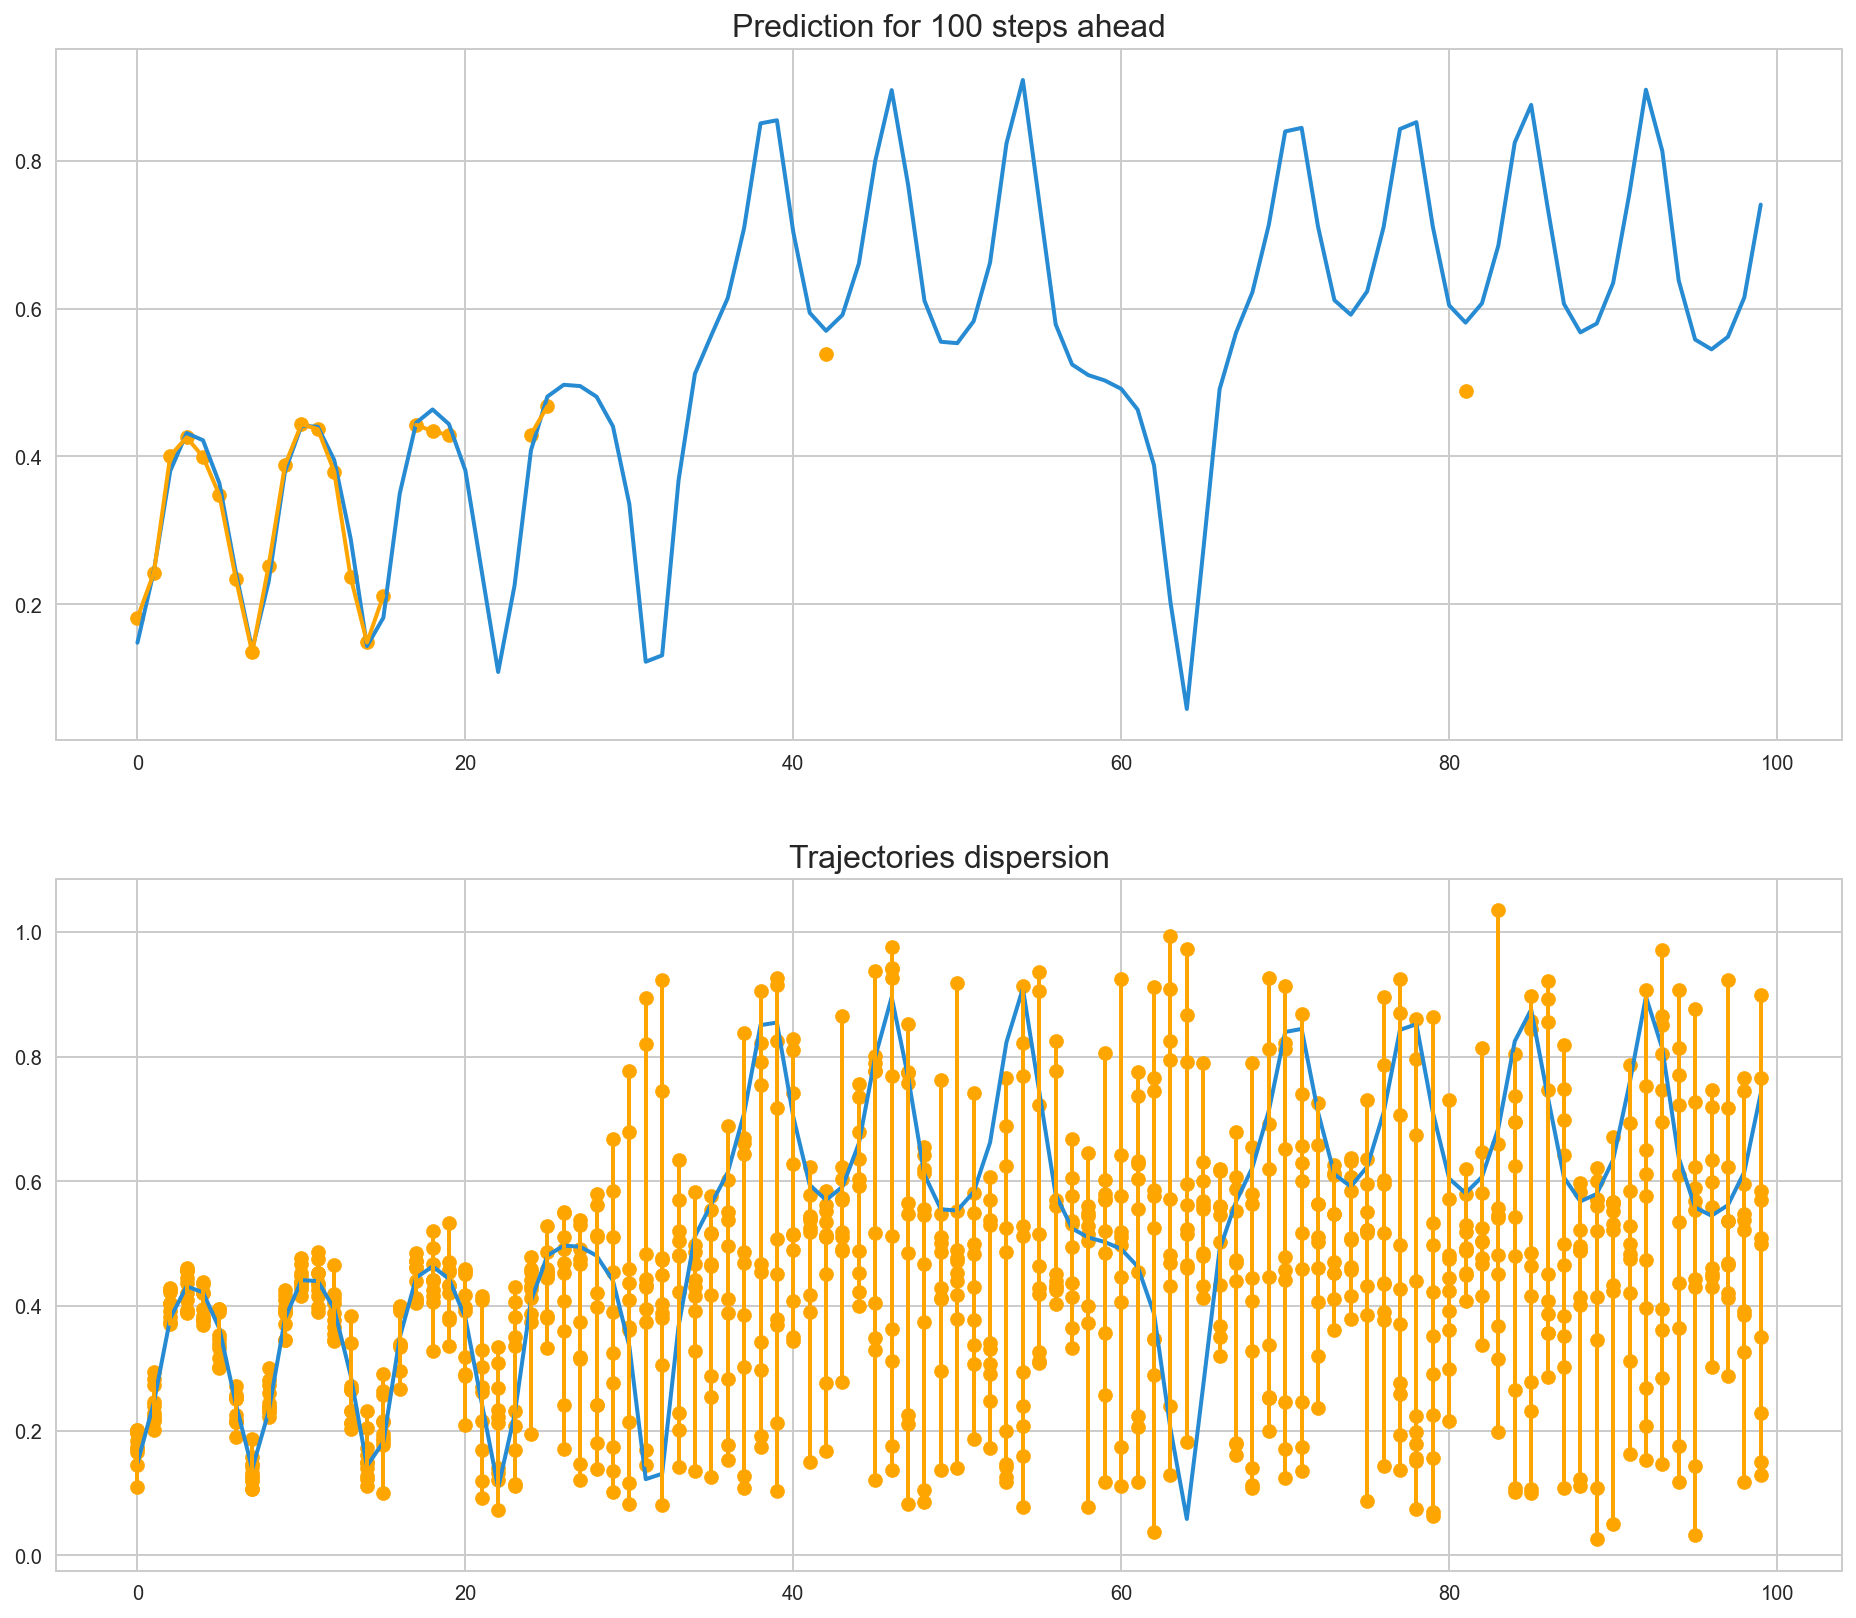

In [187]:
plot_predict(lorenz_ts, split, steps, eps, n_tr,
             noise_amp, patt_len, max_spread,
             dbs_eps, dbs_min_samples)

We see that in points where dispersion is high the algorithm avoids to make a prediction.

Now let's test how predictive clustering works comparing it with simple averaging of predictions without using non-predictable points. We will use  MAPE and RMSE error metrics for that. 
Testing for prediction horizon 4-100 with step 2.

  0%|          | 0/49 [00:00<?, ?it/s]

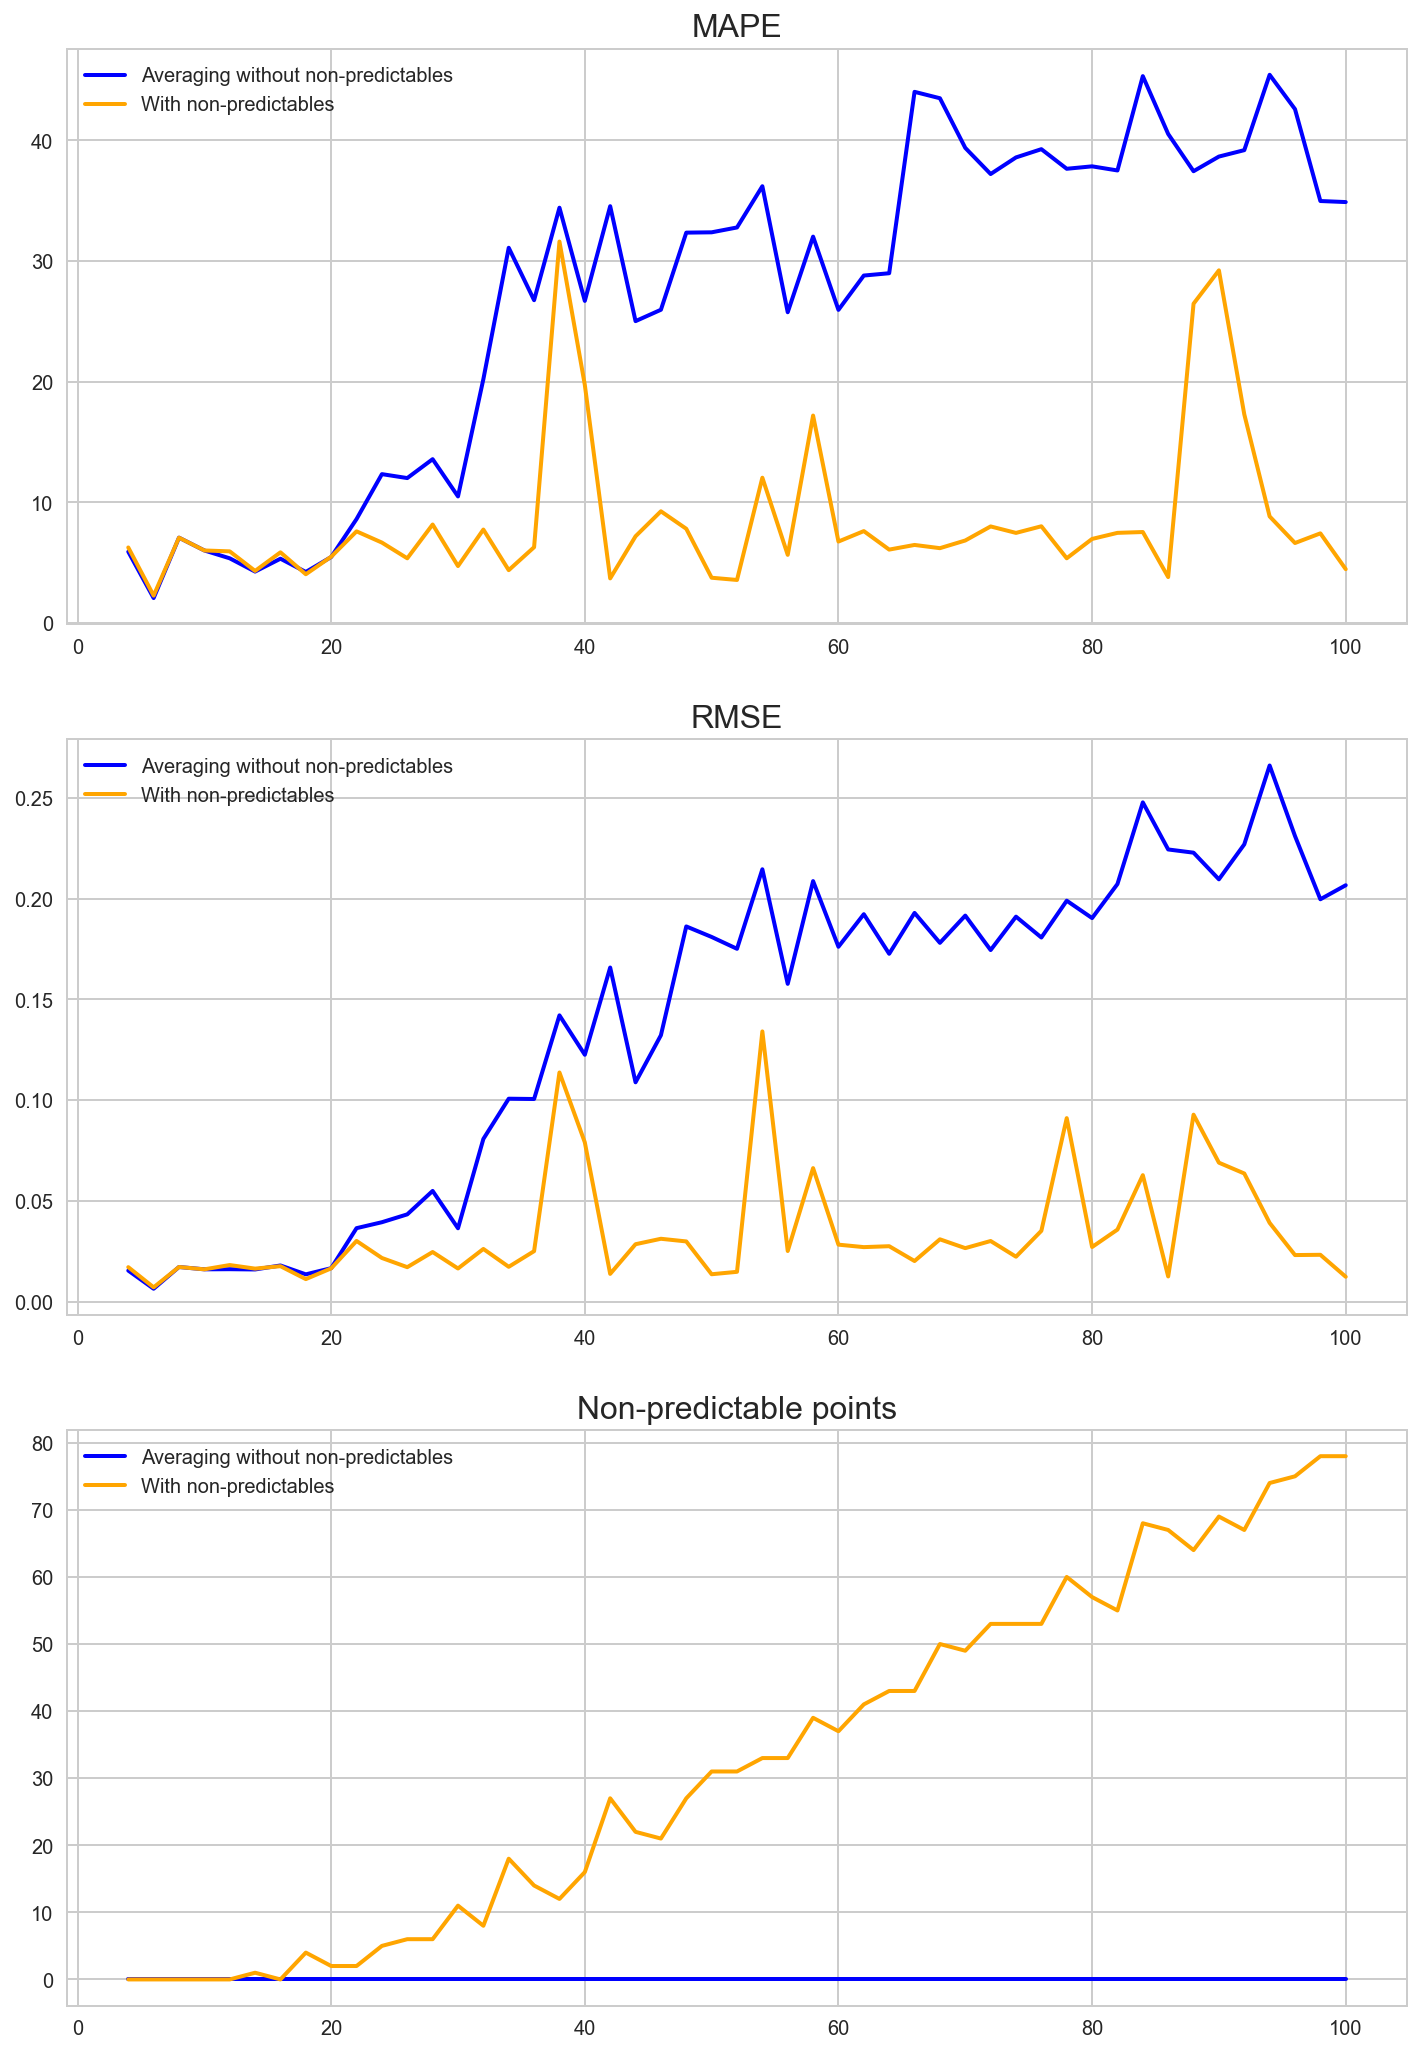

In [134]:
error_plots(lorenz_ts, split, steps_list, eps, n_tr,
            noise_amp, patt_len, max_spread,
            dbs_eps, dbs_min_samples)

As we can see from the plots, the algorithm without non-predictable points shows steady growth in both types of errors MAPE and RMSE. On the other hand if we will use non-predictable points then there is not such prominent upward trend, despite some spikes. However with increasing the horizon of prediction, the amount of non-predictable points also increases, which makes sense.

## German energy timeseries predicting

In [188]:
dbs_eps = 0.01
dbs_min_samples = 4

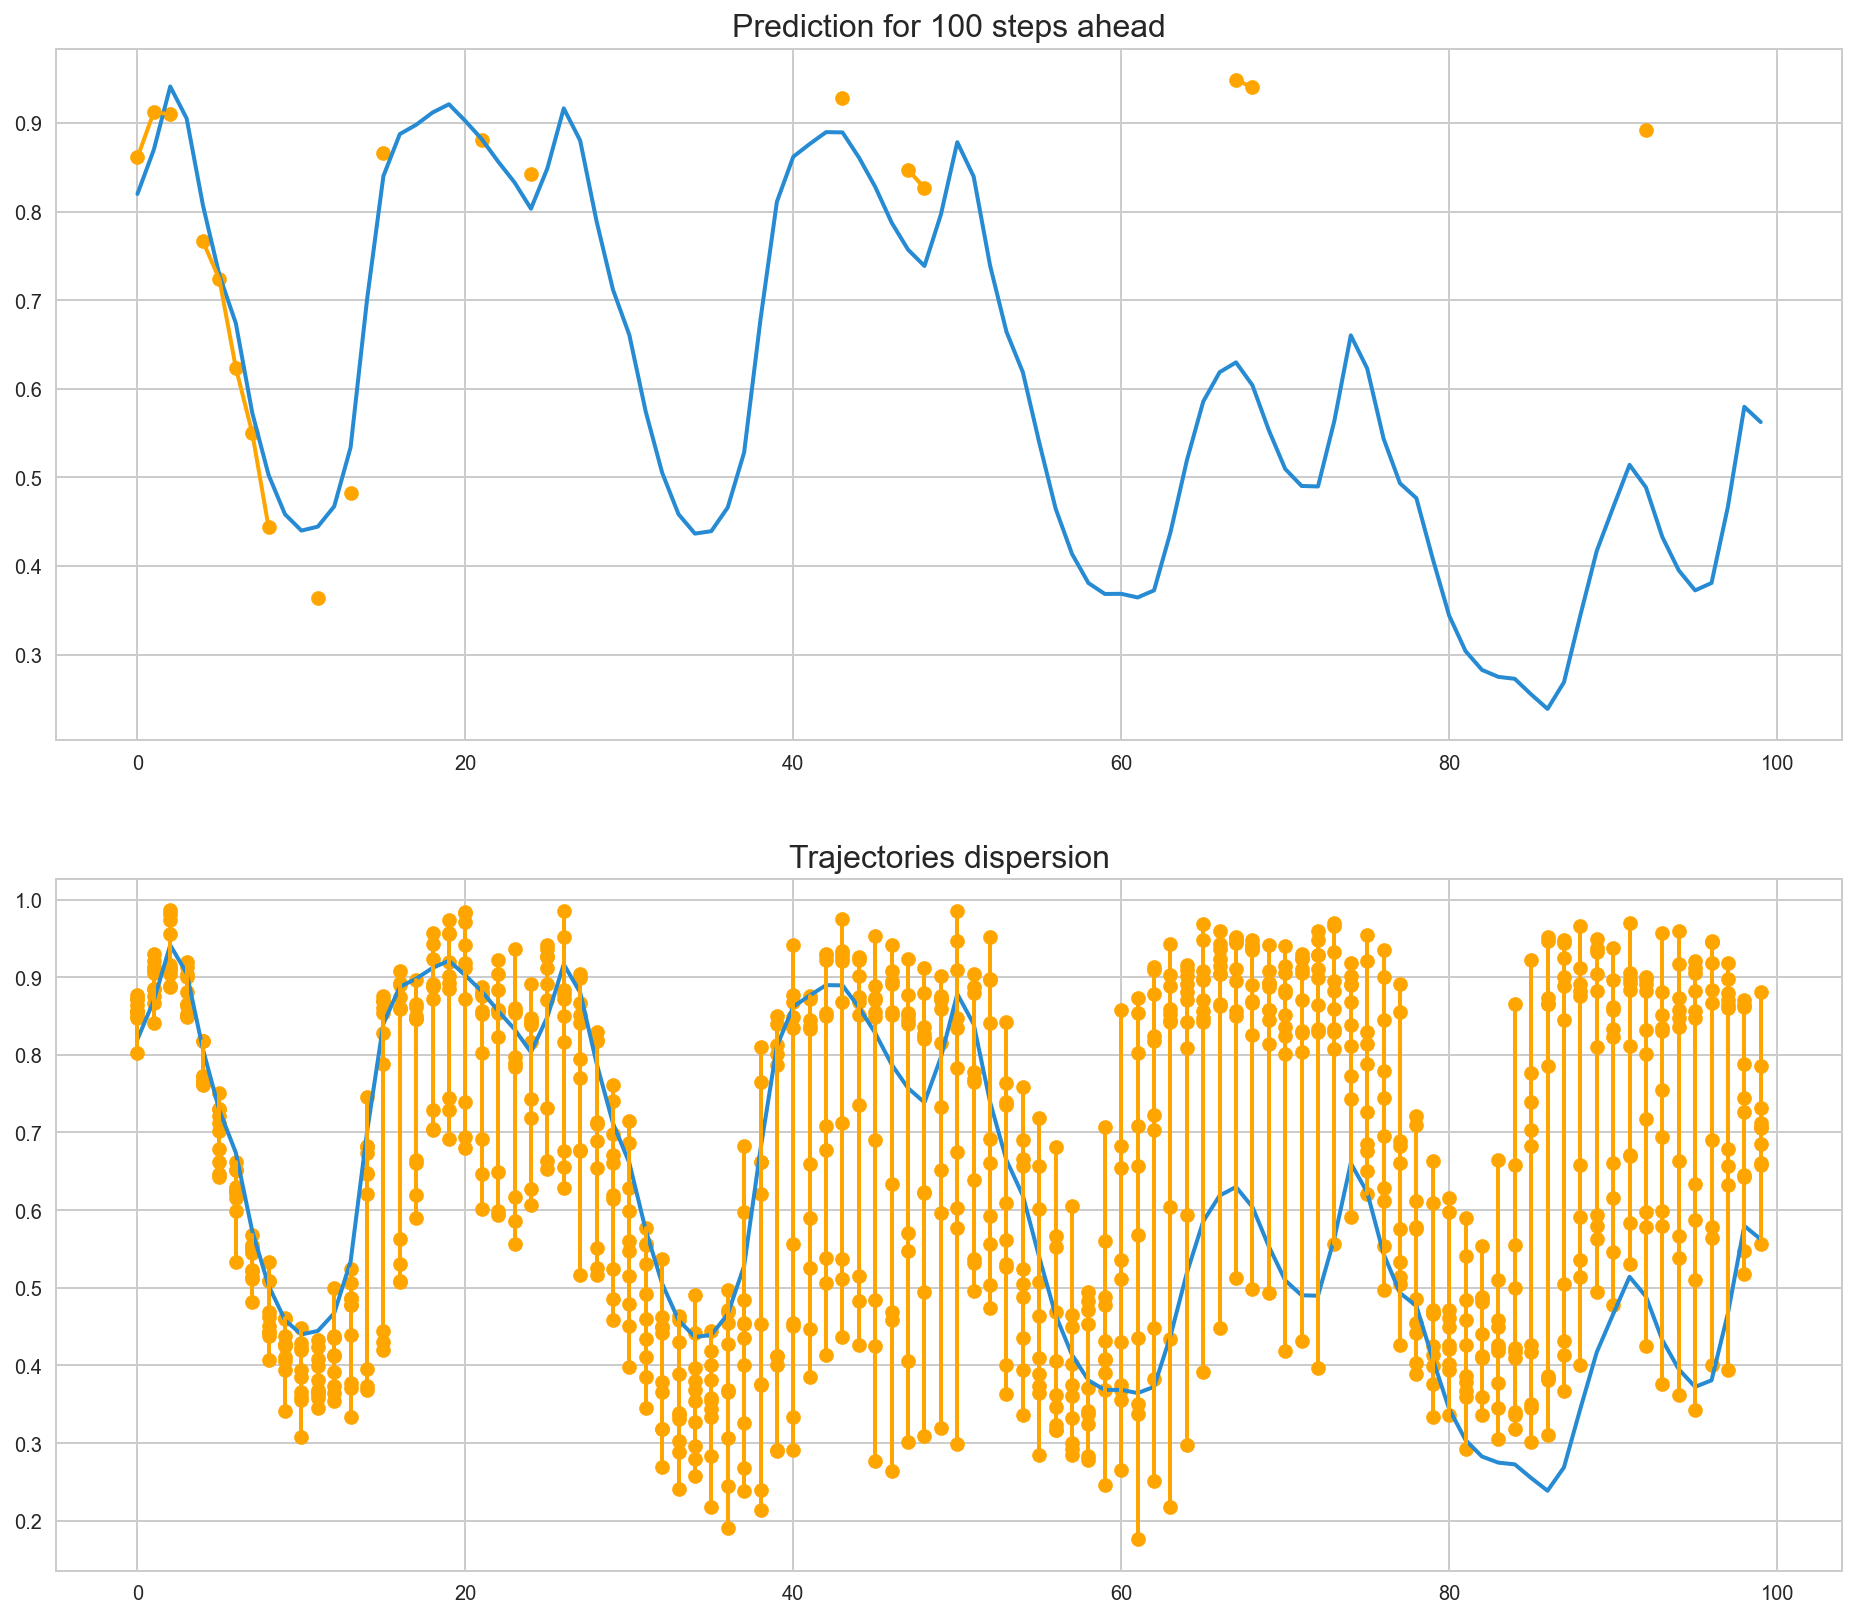

In [189]:
plot_predict(ger_ts, split, steps, eps, n_tr,
             noise_amp, patt_len, max_spread,
             dbs_eps, dbs_min_samples)

  0%|          | 0/49 [00:00<?, ?it/s]

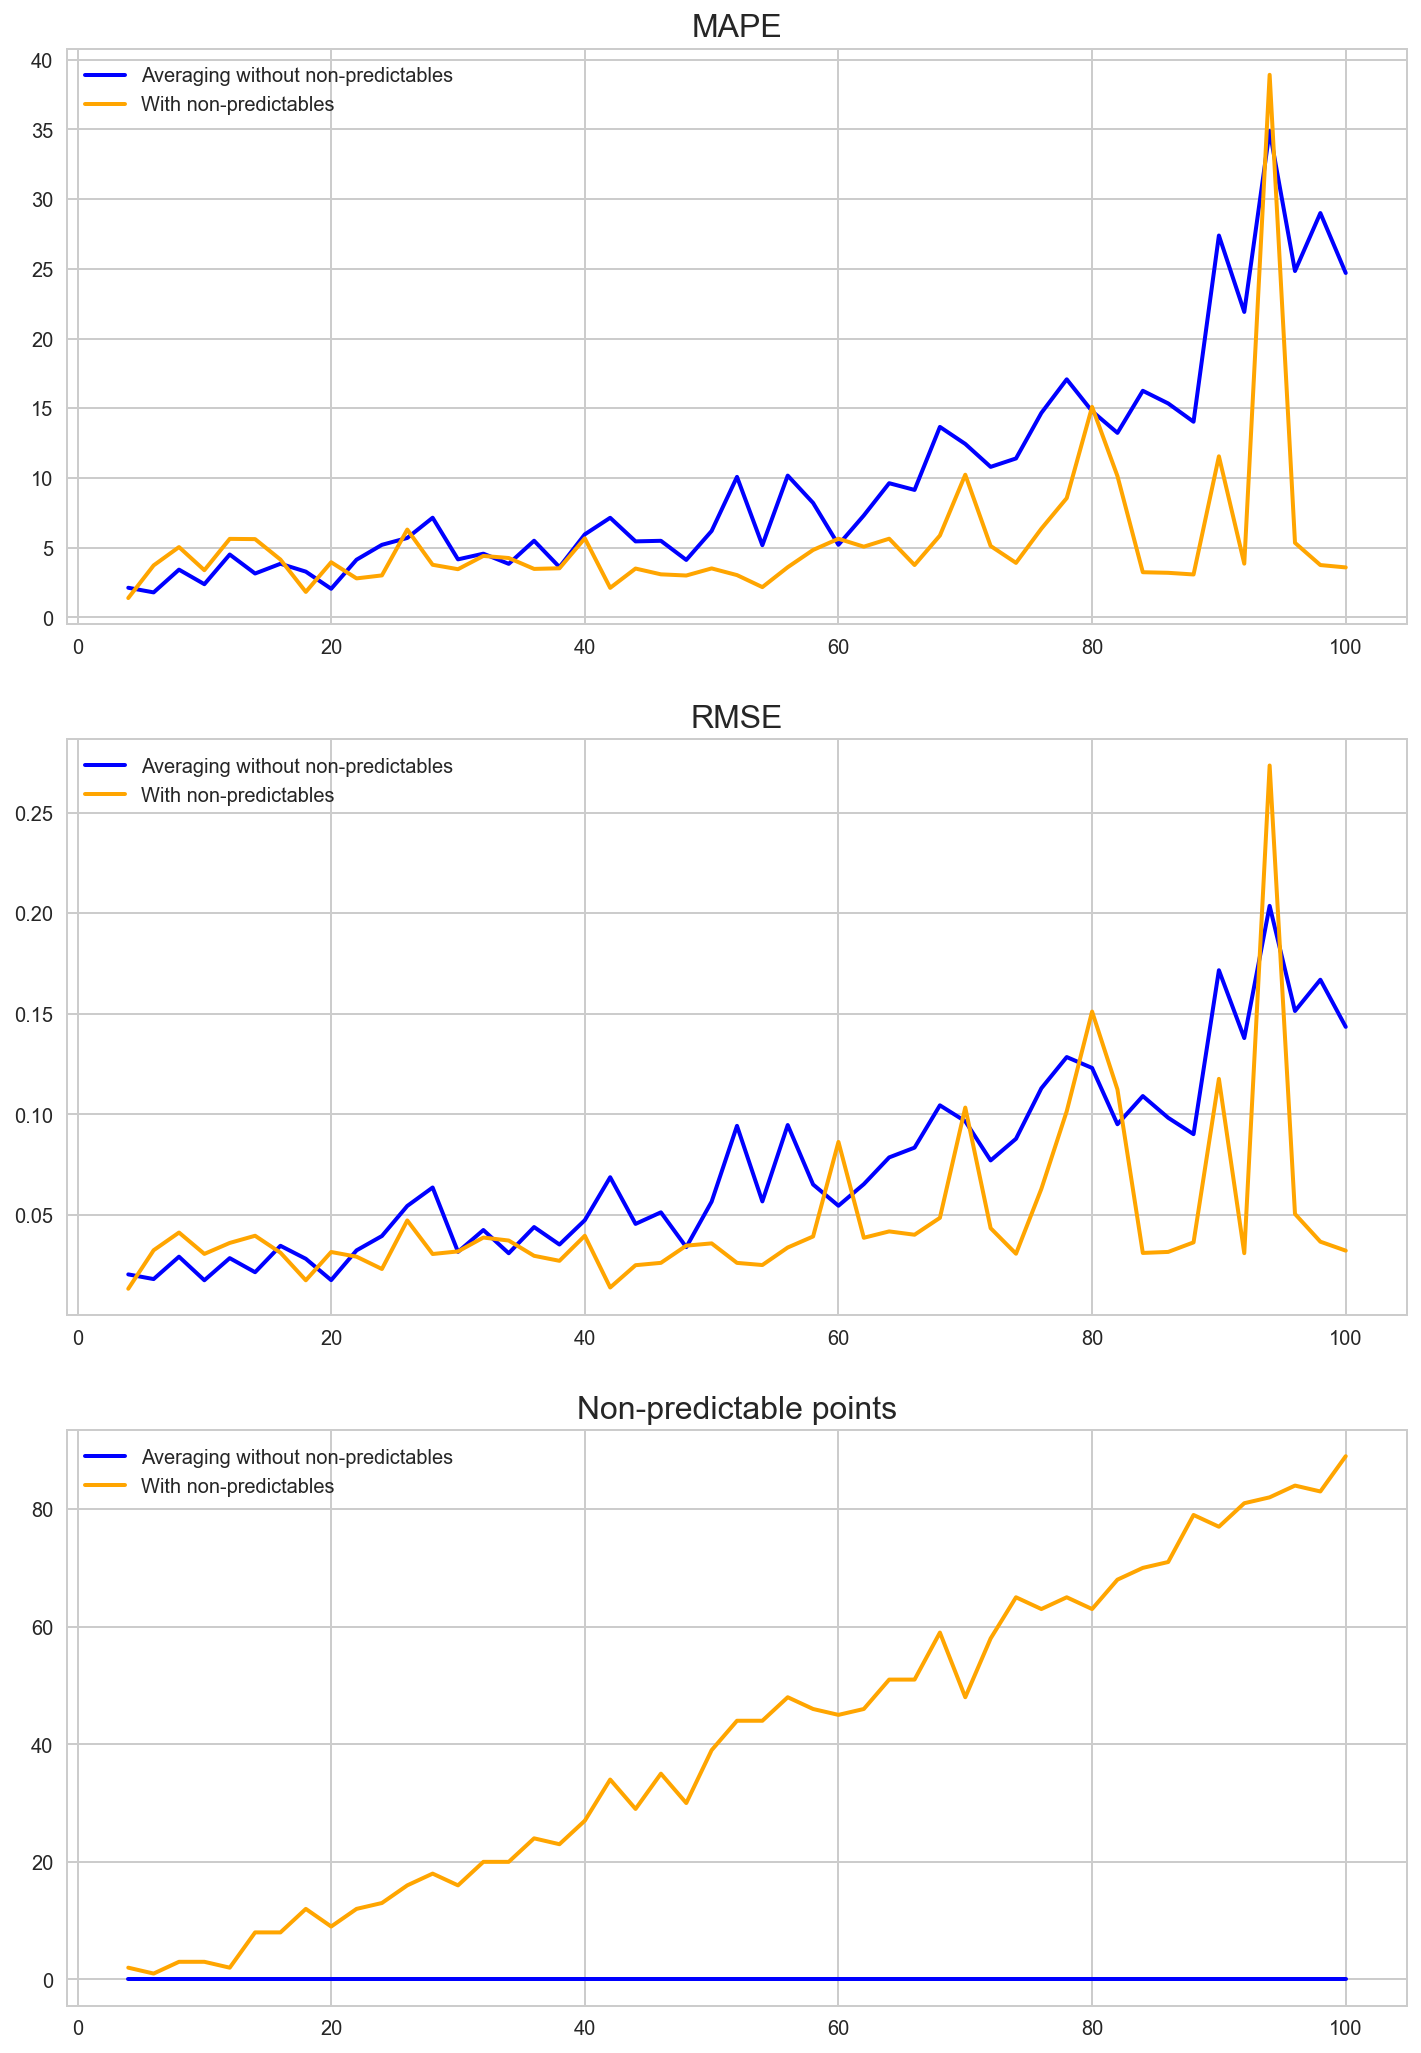

In [158]:
error_plots(ger_ts, split, steps_list, eps, n_tr,
            noise_amp, patt_len, max_spread,
            dbs_eps, dbs_min_samples)

As we can see the result for this timeseries is less favourable for predictive clustering algorithm. Despite it still being better then simple averaging in terms of errors, the difference is not that big. This is mostly due to the fact that this time simeries is less chaotic, or it's deterministic inner structure contains some trends which were not catched by predictive clustering motifs due to their length.

## EUR-USD FX timeseries predicting

For this timeseries we will reduce noice amplitude, considering that data is already highly stohastic and noisy.

In [216]:
noise_amp = 0.01
dbs_eps = 0.01
dbs_min_samples = 4

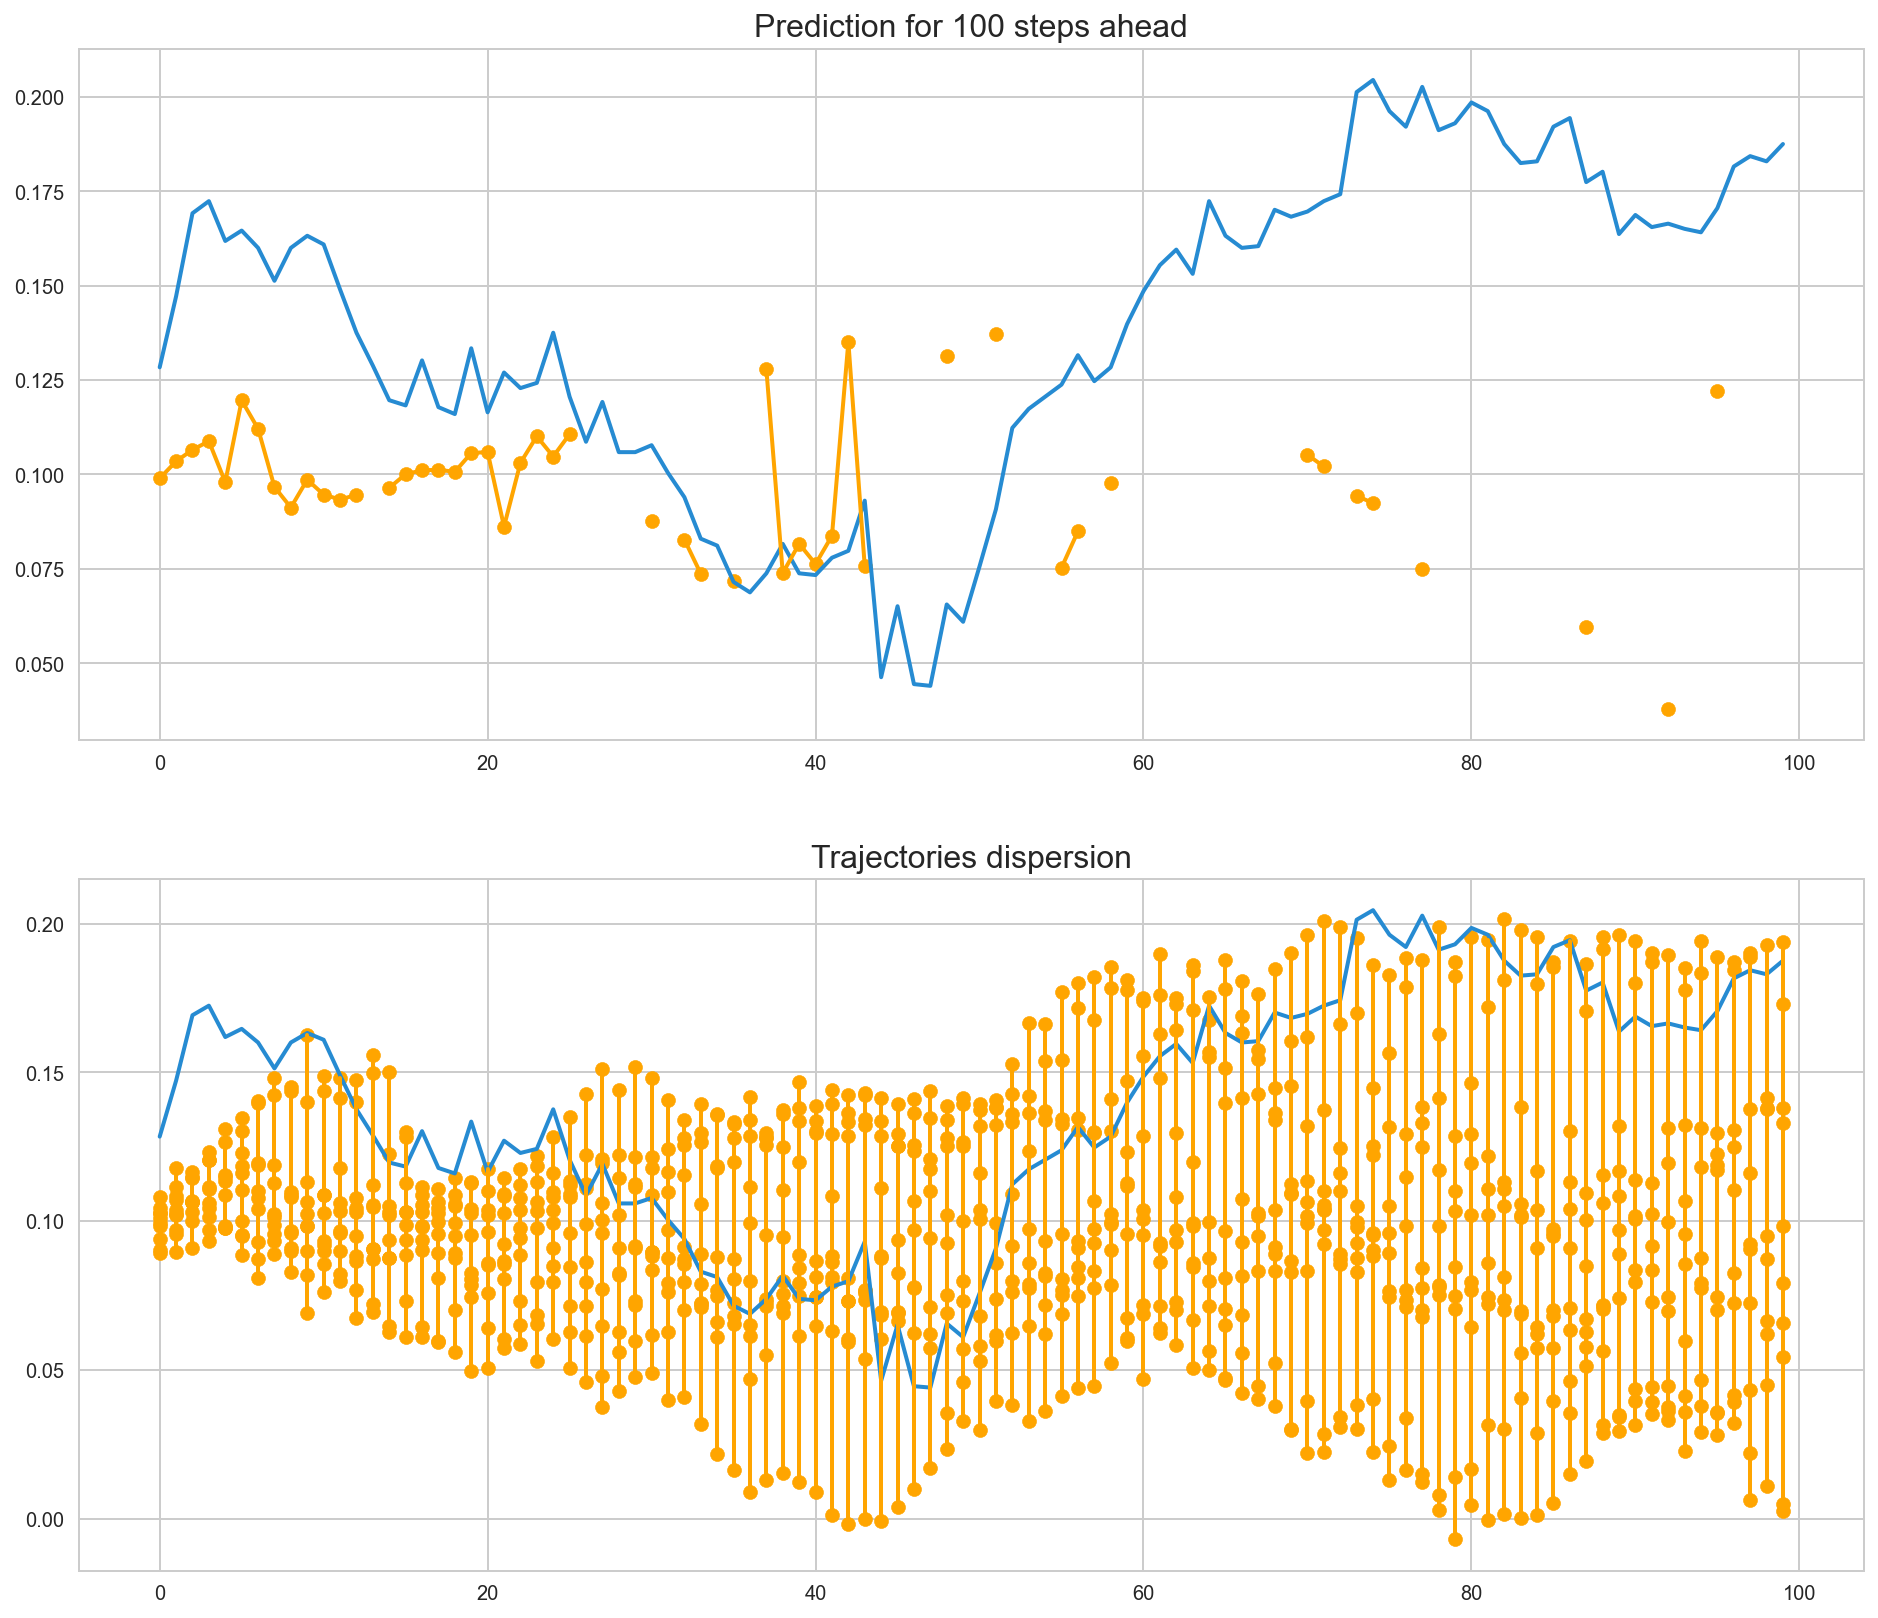

In [217]:
plot_predict(fx_ts, split, steps, eps, n_tr,
             noise_amp, patt_len, max_spread,
             dbs_eps, dbs_min_samples)

  0%|          | 0/49 [00:00<?, ?it/s]

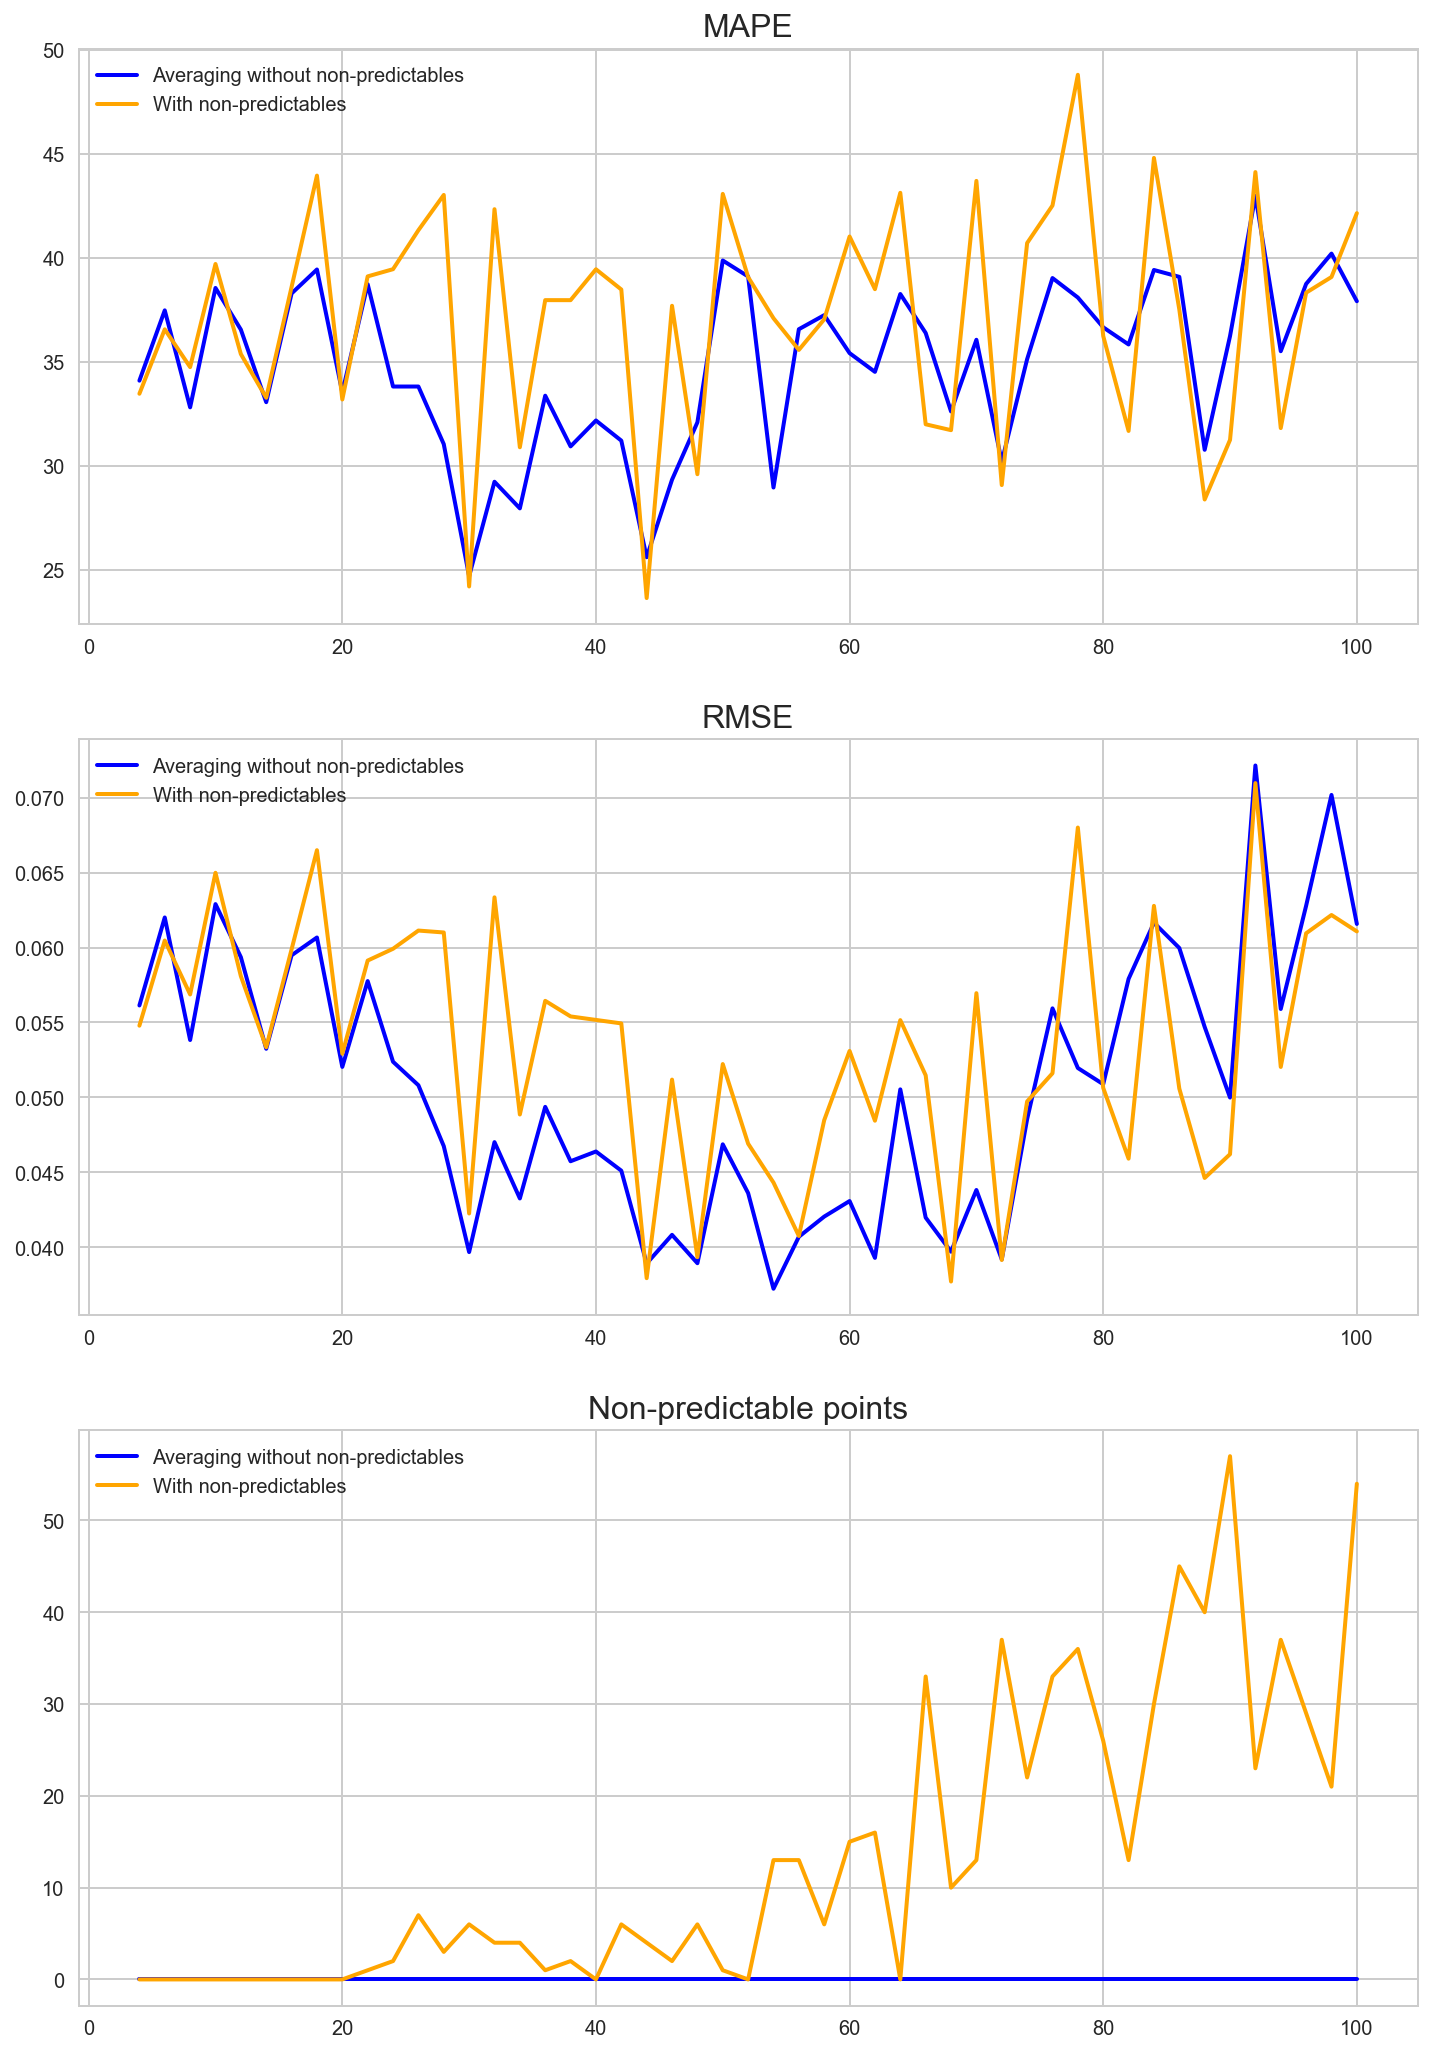

In [218]:
error_plots(fx_ts, split, steps_list, eps, n_tr,
            noise_amp, patt_len, max_spread,
            dbs_eps, dbs_min_samples)

For stohastic timeseries the algorithm works weidly with errors oscillating randomly. Is is obvious that we cannot use predictive clustering approach in that case.

# Conclusion

For chaotic timeseries the predictive clustering with non-predictable points algorithm showed tangible increase in performance comapring with just averaging. There is a lot of place for improvement though. Due to computational cost restrictments, all data was trained using only 1000 point training set, the pattern length was chosen to be 4, and the number of trajectories - 10. All those can be inrease, possibly facilitating the power of algorithm. Also, the choice of clustering algorithm is important. In this work the DBSCAN clustering was used, which requires careful finetuning of epsilon and min_number_of_samples parameters for algorithm to be optimal in teamrs of strictness of evaluating the non-predictable vs predictable points and also maintain the low error rate. There  are possible solutions here, to grid search for optimal parameters (computationally heavy) or use other techniques with less parameters, such as HDBSCAN or Wishart clustering. Finally, it is crucial to pay attention to the nature of data itself, because the data with non-chaotic structure could be less approachable using proposed methods and should be predicted in some other ways.